In [13]:
import sys
import os
sys.path.insert(1, os.path.realpath(os.path.pardir))

from deepmeg import read_pkl
from deepmeg.params import *
from utils.storage import DLStorageIterator
import numpy as np
import matplotlib.pyplot as plt
from mne import evoked
import mne

def plot_pattern(
    data: np.ndarray,
    info: mne.Info
):
    info.__setstate__(dict(_unlocked=True))
    info['sfreq'] = 1.
    fake_evoked = evoked.EvokedArray(np.expand_dims(data, 1), info, tmin=0)
    fig, ax1 = plt.subplots(ncols=1, nrows=1)
    fig.tight_layout()

    fig.set_size_inches(10, 5)
    fake_evoked.plot_topomap(
        times=0,
        axes=ax1,
        colorbar=False,
        scalings=1,
        time_format="",
        outlines='head',
        cmap='RdBu_r'
    )

    return fig

2022-12-11 15:21:30.115796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 15:21:30.232370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-11 15:21:30.232390: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-11 15:21:30.933752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
it = DLStorageIterator('../DATA', '6_branches_action')

for subject_name in it:
    sp = read_pkl(os.path.join(it.parameters_path, 'spatial.pkl'))
    tp = read_pkl(os.path.join(it.parameters_path, 'temporal.pkl'))
    wf = read_pkl(os.path.join(it.parameters_path, 'waveforms.pkl'))
    bl = read_pkl(os.path.join(it.parameters_path, 'branch_loss.pkl'))

In [11]:
import numpy as np

subjects_dir = '../DATA'
classification_name_formatted = 'Default_name'

class DataCollector:
    def __init__(self):
        self._induceds = list()
        self._patterns = list()
        self._induceds_filt = list()

    @property
    def induceds(self):
        return self._induceds

    @property
    def induceds_filt(self):
        return self._induceds_filt

    @property
    def patterns(self):
        return self._patterns

    @induceds.setter
    def induceds(self, value: np.ndarray):
        self._induceds.append(value)

    @induceds_filt.setter
    def induceds_filt(self, value: np.ndarray):
        self._induceds_filt.append(value)

    @patterns.setter
    def patterns(self, value: np.ndarray):
        self._patterns.append(value)

def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)


In [182]:
iterator = DLStorageIterator(subjects_dir, classification_name_formatted)
collector = DataCollector()
import scipy
import mne

tail = 0

# degrees_of_freedom = len(iterator.subject_dirs) - 1
degrees_of_freedom = 11 - 1
t_thresh = scipy.stats.t.ppf(1 - 0.001 / 2, df=degrees_of_freedom)
n_permutations = 50000

# for subject_name in iterator:
#     subject_num = int(re.findall(r'\d+', subject_name)[0])

#     if (subject_num in excluded_subjects) or\
#         (from_ and subject_num < from_) or\
#         (to and subject_num > to):
#         continue

#     sp = read_pkl(os.path.join(iterator.parameters_path, 'spatial.pkl'))
#     wf = read_pkl(os.path.join(iterator.parameters_path, 'waveforms.pkl'))
#     collector.induceds = wf.induced
#     collector.induceds_filt = wf.induced_filt
#     collector.patterns = np.reshape(sp.patterns, (sp.patterns.shape[0]*sp.patterns.shape[1]))
#     collector.sortings = np.argsort(read_pkl(os.path.join(iterator.parameters_path, 'branch_loss.pkl')))[::-1]
next(iterator)
for i in range(11):
    sp = read_pkl(os.path.join(iterator.parameters_path, 'spatial.pkl'))
    patterns = sp.patterns[:, np.argsort(read_pkl(os.path.join(iterator.parameters_path, 'branch_loss.pkl')))[::-1]]
    collector.patterns = patterns[:, :8][:, np.argsort(np.random.random((8,)))]
    # collector.induceds = induced[:8, :, :][np.argsort(np.random.random((8,)))]

patterns = np.transpose(np.array(collector.patterns), (0, 2, 1))
# patterns = np.random.random((11, 8, 204))

T_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_1samp_test(
        np.reshape(patterns, (patterns.shape[0]*patterns.shape[1], patterns.shape[2])),
        n_permutations=n_permutations,
        tail=tail,
        out_type='mask',
        threshold=t_thresh,
        verbose=True
    )


stat_fun(H1): min=-9.042308 max=13.010683
Running initial clustering …
Found 22 clusters


100%|██████████| Permuting : 49999/49999 [00:07<00:00, 6808.93it/s]


In [179]:
patterns.shape

(11, 8, 204)

In [181]:
cluster_p_values

array([2.e-05])

In [75]:
T_obs.shape

(204,)

In [77]:
info = iterator.data_paths[-1].epochs.pick_types(meg='grad').info

Reading /home/user/Projects/NeuralGeometry/dirty_field/../DATA/subj02/PreTest/PreTest_epochs_sel.fif ...


/home/user/Projects/NeuralGeometry/utils/storage.py:42: RuntimeWarning: This filename (../DATA/subj02/PreTest/PreTest_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
890 matching events found
No baseline correction applied
0 projection items activated


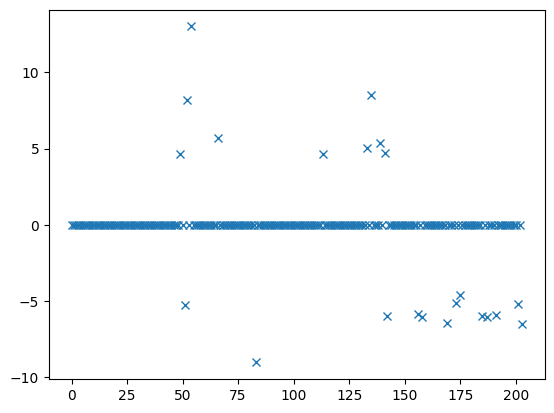

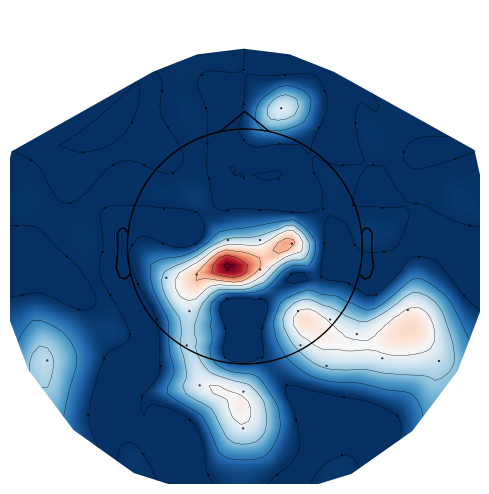

In [95]:
T_obs_plot = 0 * np.ones_like(T_obs)

for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T_obs[c]
plt.plot(T_obs_plot, 'x')
plt.show()
fig = plot_pattern(T_obs_plot, info)

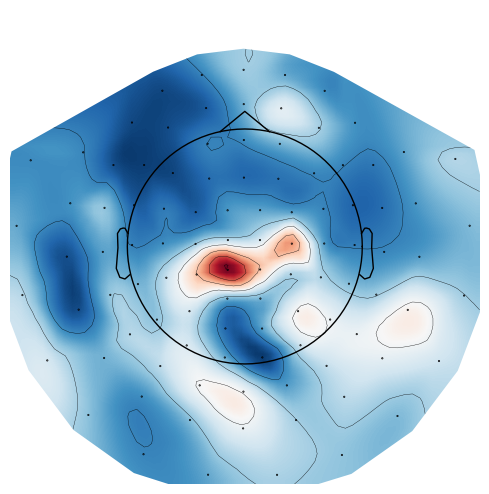

In [79]:
fig = plot_pattern(T_obs, info)

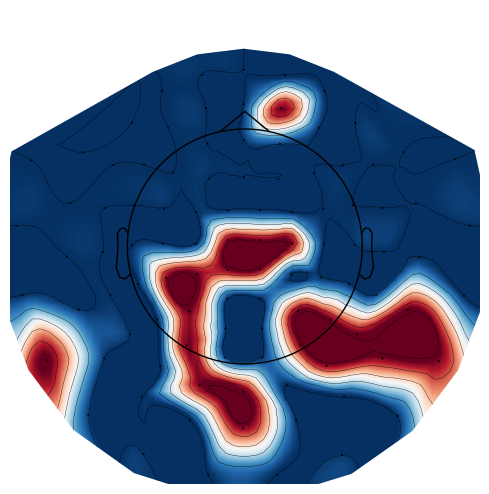

In [80]:
T_obs_plot_bin = 0 * np.ones_like(T_obs)

for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot_bin[c] = 1

fig = plot_pattern(T_obs_plot_bin, info)

In [81]:
T_obs, p_values, H0 = mne.stats.permutation_t_test(np.reshape(patterns, (patterns.shape[0]*patterns.shape[1], patterns.shape[2])), n_permutations=n_permutations,
                                tail=tail,
                                verbose=True)

Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


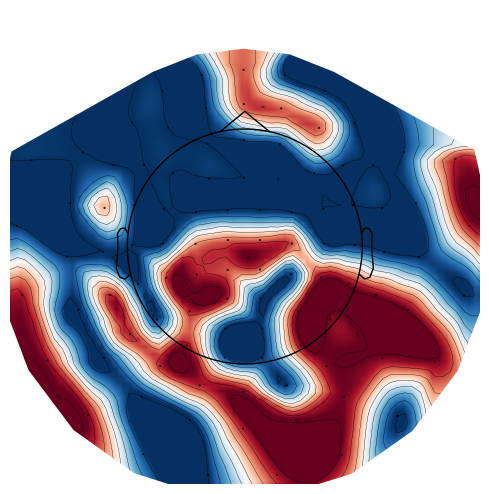

In [82]:
out = list()

for val, p in zip(H0, p_values):
    if p <= .05:
        out.append(val)
    else:
        out.append(0)

out = np.array(out)

fig = plot_pattern(out, info)

In [348]:
iterator = DLStorageIterator(subjects_dir, classification_name_formatted)
collector = DataCollector()
import scipy
import mne

tail = 0

# degrees_of_freedom = len(iterator.subject_dirs) - 1
degrees_of_freedom = 11 - 1
t_thresh = scipy.stats.t.ppf(1 - 0.001 / 2, df=degrees_of_freedom)
n_permutations = 500

# for subject_name in iterator:
#     subject_num = int(re.findall(r'\d+', subject_name)[0])

#     if (subject_num in excluded_subjects) or\
#         (from_ and subject_num < from_) or\
#         (to and subject_num > to):
#         continue

#     sp = read_pkl(os.path.join(iterator.parameters_path, 'spatial.pkl'))
#     wf = read_pkl(os.path.join(iterator.parameters_path, 'waveforms.pkl'))
#     collector.induceds = wf.induced
#     collector.induceds_filt = wf.induced_filt
#     collector.patterns = np.reshape(sp.patterns, (sp.patterns.shape[0]*sp.patterns.shape[1]))
#     collector.sortings = np.argsort(read_pkl(os.path.join(iterator.parameters_path, 'branch_loss.pkl')))[::-1]
next(iterator)
for i in range(51):
    wf = read_pkl(os.path.join(iterator.parameters_path, 'waveforms.pkl'))
    bl = read_pkl(os.path.join(iterator.parameters_path, 'branch_loss.pkl'))
    induced = wf.induced[np.argsort(bl)[::-1], :, :]
    induced_filt = wf.induced_filt[np.argsort(bl)[::-1], :, :]
    fake_data = (2*np.random.random((1, 99, 200))) - 1
    a, b = np.random.randint(50), np.random.randint(100)
    fake_data[0, :a, b:] = 10*np.abs(fake_data[0, :a, b:])
    collector.induceds = fake_data
    # collector.induceds = induced[:8, :, :][np.argsort(np.random.random((8,)))]
    # collector.induceds_filt = induced_filt[:8, :, :][np.argsort(np.random.random((8,)))]

induceds = np.array(collector.induceds)
induceds_filt = np.array(collector.induceds_filt)

data = np.reshape(induceds, (induceds.shape[0]*induceds.shape[1], *induceds.shape[2:]))

# data = np.array([
#     [freq/freq.mean() for freq in sample] for sample in data
# ])

T_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_1samp_test(
        data,
        n_permutations=5000,
        tail=tail,
        out_type='mask',
        threshold=t_thresh,
        verbose=True
    )


stat_fun(H1): min=-4.477794 max=15.391504
Running initial clustering …
Found 80 clusters


100%|██████████| Permuting : 4999/4999 [00:20<00:00,  240.79it/s]


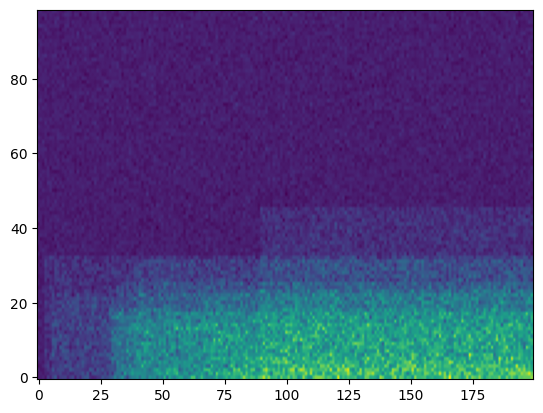

In [347]:
plt.imshow(data.mean(0), aspect='auto',  origin='lower')

In [330]:
data.T.shape

(200, 99, 11)

In [339]:
np.round(cluster_p_values, 2)

array([0., 0., 0., ..., 0., 0., 0.])

In [248]:
T_obs.shape

(99, 200)

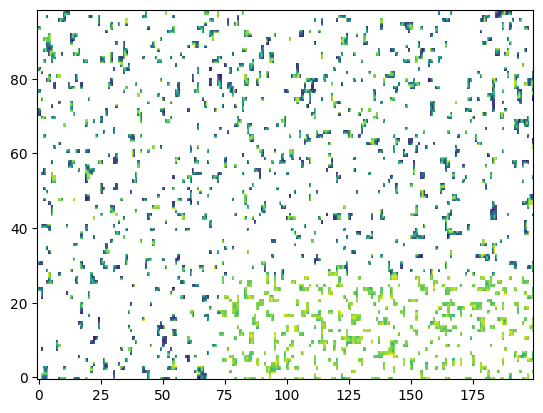

In [340]:
plt.imshow(T_obs, aspect='auto', origin='lower')


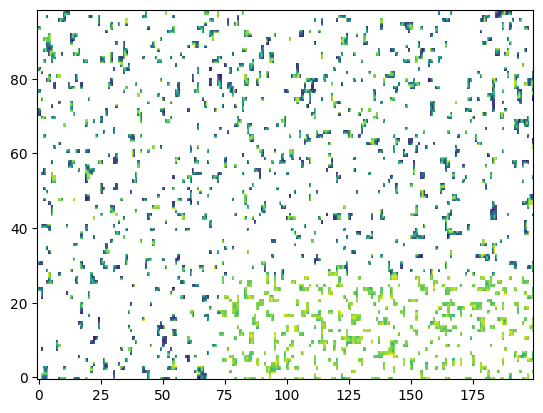

In [345]:
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T_obs[c]

plt.imshow(T_obs_plot, aspect='auto',  origin='lower')

In [134]:
data = np.reshape(induceds, (induceds.shape[0]*induceds.shape[1], *induceds.shape[2:])).copy()

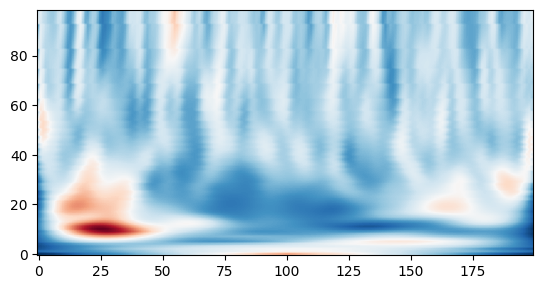

In [135]:
ind = np.array([
    freq/freq.mean()
    for freq in data[2]
])

plt.imshow(ind,
    cmap='RdBu_r',
    origin='lower'
)

In [40]:
wf.induced.shape

(16, 99, 200)

In [37]:
collector.induceds[0].shape

(8, 99, 200)

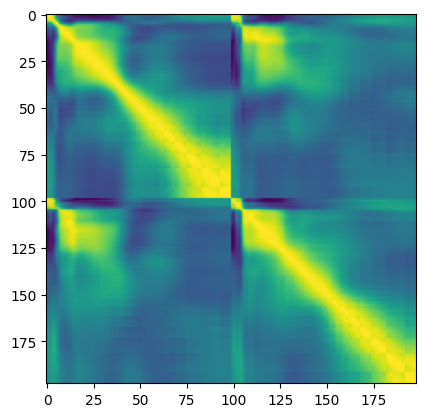

In [100]:
plt.imshow(np.corrcoef(data[1], data[2]))

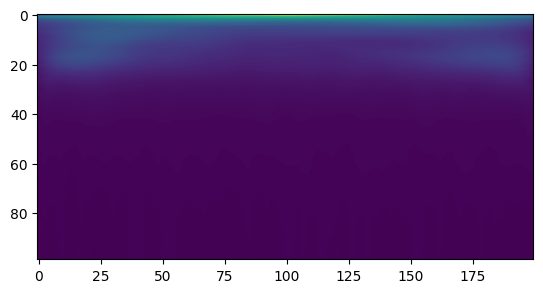

In [136]:
plt.imshow(data.mean(0))

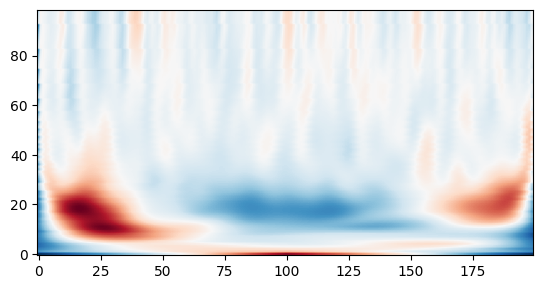

In [137]:
ind = np.array([
    freq/freq.mean()
    for freq in data.mean(0)
])

plt.imshow(ind,
    cmap='RdBu_r',
    origin='lower'
)

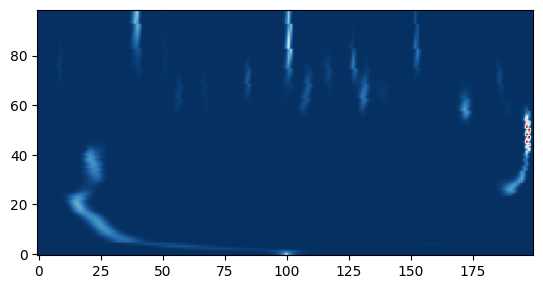

In [141]:
from functools import reduce

data[0] = data[0]/np.linalg.norm(data[0])#np.abs(data[0]).mean()

res = reduce(
    lambda x, y: x*y/np.linalg.norm(data[0]),#(np.abs(y).mean()),
    data
)

ind = np.array([
    freq/freq.mean()
    for freq in res
])

plt.imshow(ind,
    cmap='RdBu_r',
    origin='lower'
)